In [1]:
import os

os.environ["BRASA_DATA_PATH"] = "D:\\brasa"

In [2]:
import sys
sys.path.append('..')

from datetime import datetime

import numpy as np
import pandas as pd
import pyarrow.dataset as ds
import pyarrow.compute as pc
import pyarrow

import brasa

man = brasa.engine.CacheManager()

In [3]:
from bizdays import Calendar, set_option

set_option("mode", "pandas")
cal = Calendar.load("B3")

In [58]:
ds_cotahist = brasa.get_dataset("b3-cotahist")
df_cotahist = ds_cotahist\
        .filter(pc.field("refdate") >= cal.startdate)\
        .filter(pc.field("instrument_market") == 10)\
        .filter(pc.field("bdi_code") == 14)\
        .filter(pc.is_in(pc.utf8_slice_codeunits(pc.field("isin"), 6, 9), pyarrow.array(["CTF"])))\
        .filter(pc.starts_with(pc.field("specification_code"), "CI"))\
        .scanner(columns=["refdate", "symbol", "close"])\
        .to_table()\
        .to_pandas()
df_cotahist

,refdate,symbol,close
0,2000-03-27,FNAM11,0.14
1,2000-03-28,FNAM11,0.15
2,2000-03-29,FNAM11,0.15
3,2000-03-30,FNAM11,0.15
4,2000-04-04,FNAM11,0.16
...,...,...,...
113148,2023-12-13,ESGE11,6.85
113149,2023-12-13,ESGU11,8.72
113150,2023-12-13,ETHE11,32.80
113151,2023-12-13,EURP11,10.09


In [59]:
ds_eq_sm = brasa.get_dataset("b3-equities-spot-market")
ds_md = brasa.get_dataset("b3-bvbg086")
symbols = ds_eq_sm\
    .filter(pc.field("instrument_market") == 10)\
    .filter(pc.field("security_category") == 3)\
    .filter(pc.is_in(pc.utf8_slice_codeunits(pc.field("isin"), 6, 9), pyarrow.array(["CTF"])))\
    .filter(pc.starts_with(pc.field("specification_code"), "CI"))\
    .scanner(columns=["symbol"])\
    .to_table()\
    .column("symbol")\
    .unique()
df_bvbg = ds_md\
    .filter(pc.field("symbol").isin(symbols))\
    .scanner(columns=["refdate", "symbol", "close"])\
    .to_table()\
    .to_pandas()
df_bvbg

,refdate,symbol,close
0,2018-01-02,SMAL11,81.50
1,2018-01-02,BOVV11,78.10
2,2018-01-02,XBOV11,77.00
3,2018-01-02,GOVE11,32.88
4,2018-01-02,ECOO11,84.55
...,...,...,...
31895,2023-12-15,MATB11,58.79
31896,2023-12-15,BOVA11,126.28
31897,2023-12-15,XBOV11,128.85
31898,2023-12-15,ECOO11,109.73


In [63]:
# df_cotahist_bvbg = df_cotahist.join(df_bvbg, on=["refdate", "symbol"], how="outer")
# df_cotahist_bvbg
df_cotahist_bvbg = pd.merge(df_cotahist, df_bvbg, on=["refdate", "symbol"], how="outer", suffixes=("_cotahist", "_bvbg"))
fill_bvbg = df_cotahist_bvbg["close_bvbg"].isna() & ~df_cotahist_bvbg["close_cotahist"].isna()
df_cotahist_bvbg["close"] = df_cotahist_bvbg["close_bvbg"]
df_cotahist_bvbg.loc[fill_bvbg, "close"] = df_cotahist_bvbg.loc[fill_bvbg, "close_cotahist"]
# df_etf_cotahist.loc[ix_cotahist, "close"] = df_etf_cotahist.loc[ix_cotahist, "close_bvbg"]
df_cotahist_bvbg

,refdate,symbol,close_cotahist,close_bvbg,close
0,2000-03-27,FNAM11,0.14,NaN,0.14
1,2000-03-28,FNAM11,0.15,NaN,0.15
2,2000-03-29,FNAM11,0.15,NaN,0.15
3,2000-03-30,FNAM11,0.15,NaN,0.15
4,2000-04-04,FNAM11,0.16,NaN,0.16
...,...,...,...,...,...
114653,2023-10-05,ECOO11,NaN,NaN,NaN
114654,2023-10-20,ECOO11,NaN,NaN,NaN
114655,2023-10-25,ECOO11,NaN,NaN,NaN
114656,2023-11-01,DVER11,NaN,NaN,NaN


In [65]:
etf_prices = df_cotahist_bvbg.pivot_table(values="close", index="refdate", columns="symbol")
etf_prices

symbol,5GTK11,AATH11,ACWI11,AEFI11,AGRI11,ALMI11B,ALUG11,ASIA11,BBFI11B,BBOI11,...,WRLD11,XBOV11,XFIX11,XINA11,XMAL11,XPID11,XPIE11,XPOM11,XPTD11,YDRO11
refdate,,,,,,,,,,,,,,,,,,,,,
2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-11,79.74,NaN,10.06,NaN,49.19,NaN,33.40,NaN,NaN,7.61,...,86.61,124.35,11.35,4.99,NaN,84.41,81.20,NaN,NaN,34.58
2023-12-12,80.09,NaN,10.15,NaN,49.12,NaN,33.55,NaN,NaN,7.62,...,87.32,123.82,11.25,5.06,NaN,84.21,81.30,NaN,NaN,34.21
2023-12-13,80.42,NaN,10.19,NaN,49.90,NaN,34.29,NaN,NaN,7.64,...,87.79,126.80,11.31,5.00,NaN,84.13,81.48,NaN,NaN,35.28


In [66]:
idx = cal.seq(etf_prices.index[0], etf_prices.index[-1])
etf_prices = etf_prices.reindex(idx)

In [70]:
etfs = ["BBOV11",
        "BOVB11",
        "IBOB11",
        "XBOV11",
        "BOVA11",
        "BOVV11",
        "BOVS11",
        "BOVX11",
        "PIBB11"]

<Axes: >

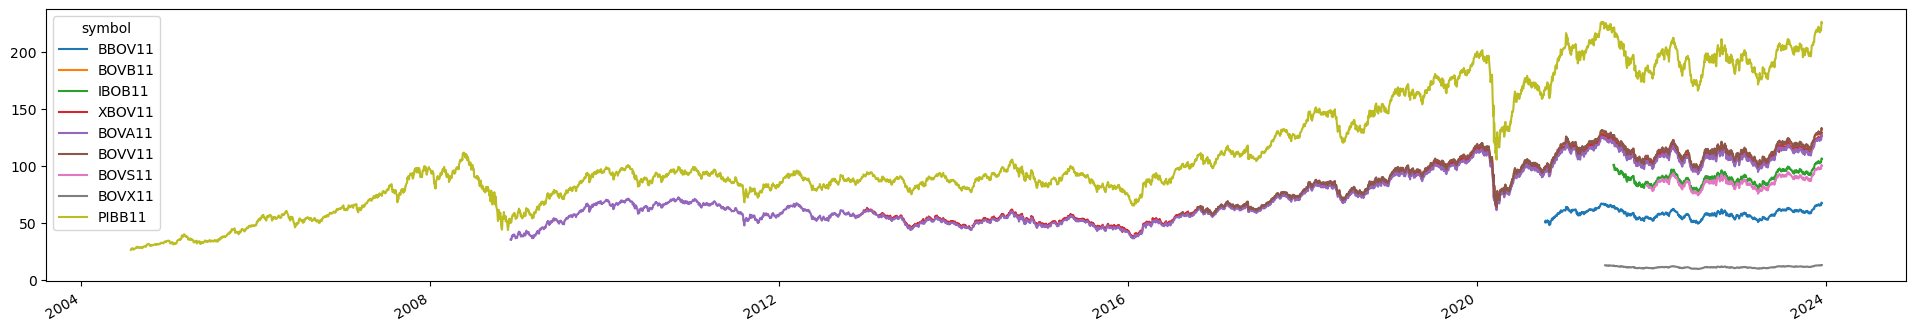

In [71]:
etf_prices.loc[:, etfs].plot(figsize=(24, 4))

<Axes: >

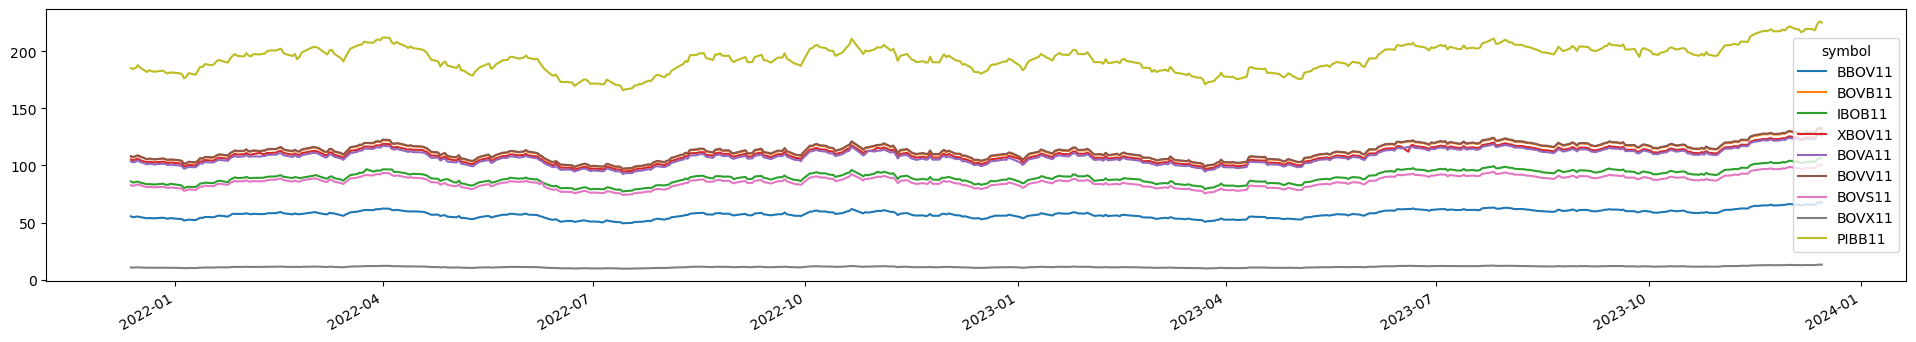

In [75]:
etf_prices.loc[:, etfs].dropna(axis=0).plot(figsize=(24, 4))